In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm 
import math
import utils.prepareDataCSV as prepare
import utils.baselineModels as baseline
import utils.train as train
import utils.plot as p

import torch
import torch.nn.functional as F
from torchinfo import summary
import torch.nn as nn
%matplotlib inline

/cloud/myenv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# 在乱序的数据集上面跑模型，注意：y仍然是按照原序的数据集来计算得到的

In [6]:
traint7path = '../../data/random_processed/stock0/randomOrder_train7_part0.csv'
test7path = '../../data/random_processed/stock0/randomOrder_test7_part0.csv'
test8path = '../../data/random_processed/stock0/randomOrder_test8_part0.csv'
test9path = '../../data/random_processed/stock0/randomOrder_test9_part0.csv'
dec_train, dec_val, dec_test = prepare.splitDataset(0.8,0.8,traint7path,test7path,test8path,test9path)
train_loader, val_loader, test_loader = prepare.getDataLoader(dec_train,dec_val,dec_test,k=4,num_classes=3,T=100,batch_size=64)

In [7]:
class LstmNet(nn.Module):
    def __init__(self, y_len, device, hidden_size=64):
        self.device = device
        self.hidden_size = hidden_size
        super(LstmNet, self).__init__()
        self.conv1 = nn.Sequential( nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1,2), stride=(1,2)),
                                    nn.LeakyReLU(negative_slope=0.01),
                                    nn.BatchNorm2d(32),
                                    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
                                    nn.LeakyReLU(negative_slope=0.01),
                                    nn.BatchNorm2d(32),
                                    )
        self.conv2 = nn.Sequential(
                                    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,2), stride=(1,2)),
                                    nn.Tanh(),
                                    nn.BatchNorm2d(32),
                                    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
                                    nn.Tanh(),
                                    nn.BatchNorm2d(32),
                                )
        self.conv3 = nn.Sequential( nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,10)),
                                    nn.LeakyReLU(negative_slope=0.01),
                                    nn.BatchNorm2d(32),
                                    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
                                    nn.LeakyReLU(negative_slope=0.01),
                                    nn.BatchNorm2d(32),
                                    )
        # set size
        self.lstm = nn.LSTM(input_size=32, hidden_size=hidden_size, num_layers=1, batch_first=True)
        # self.relu = nn.LeakyReLU(negative_slope=0.01),
        self.fc1 = nn.Linear(hidden_size, y_len)     

    def forward(self, x):
        # h0: (number of hidden layers, batch size, hidden size)
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(self.device)
    
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x = x.permute(0, 2, 1, 3)
        x = torch.reshape(x, (-1, x.shape[1], x.shape[2]))
        x, _ = self.lstm(x, (h0, c0))
        x = x[:, -1, :]
  
        x = self.fc1(x)
        forecast_y = torch.softmax(x, dim=1)
        return forecast_y

In [10]:
model = LstmNet(y_len=3, device=device, hidden_size=64)
model.to(device)

LstmNet(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): Tanh()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): Tanh()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 10), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32

In [11]:
summary(model, (64, 1, 100, 40))

Layer (type:depth-idx)                   Output Shape              Param #
LstmNet                                  --                        --
├─Sequential: 1-1                        [64, 32, 97, 20]          --
│    └─Conv2d: 2-1                       [64, 32, 100, 20]         96
│    └─LeakyReLU: 2-2                    [64, 32, 100, 20]         --
│    └─BatchNorm2d: 2-3                  [64, 32, 100, 20]         64
│    └─Conv2d: 2-4                       [64, 32, 97, 20]          4,128
│    └─LeakyReLU: 2-5                    [64, 32, 97, 20]          --
│    └─BatchNorm2d: 2-6                  [64, 32, 97, 20]          64
├─Sequential: 1-2                        [64, 32, 94, 10]          --
│    └─Conv2d: 2-7                       [64, 32, 97, 10]          2,080
│    └─Tanh: 2-8                         [64, 32, 97, 10]          --
│    └─BatchNorm2d: 2-9                  [64, 32, 97, 10]          64
│    └─Conv2d: 2-10                      [64, 32, 94, 10]          4,128
│    └

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
train_losses, val_losses = train.batch_gd(model, criterion, optimizer, train_loader, val_loader, epochs=50, device=device, savedModelName='./savedModels_randomOrder/LSTM')

  2%|▏         | 1/50 [00:07<05:50,  7.15s/it]

model saved
Epoch 1/50, Train Loss: 1.0709,           Validation Loss: 1.0545, Duration: 0:00:07.145034, Best Val Epoch: 0


  4%|▍         | 2/50 [00:14<05:37,  7.04s/it]

model saved
Epoch 2/50, Train Loss: 1.0554,           Validation Loss: 1.0539, Duration: 0:00:06.958972, Best Val Epoch: 1


  6%|▌         | 3/50 [00:21<05:29,  7.02s/it]

model saved
Epoch 3/50, Train Loss: 1.0543,           Validation Loss: 1.0537, Duration: 0:00:06.994427, Best Val Epoch: 2


  8%|▊         | 4/50 [00:28<05:24,  7.06s/it]

model saved
Epoch 4/50, Train Loss: 1.0512,           Validation Loss: 1.0504, Duration: 0:00:07.135409, Best Val Epoch: 3


 10%|█         | 5/50 [00:35<05:18,  7.08s/it]

model saved
Epoch 5/50, Train Loss: 1.0437,           Validation Loss: 1.0455, Duration: 0:00:07.097705, Best Val Epoch: 4


 12%|█▏        | 6/50 [00:42<05:10,  7.07s/it]

model saved
Epoch 6/50, Train Loss: 1.0365,           Validation Loss: 1.0450, Duration: 0:00:07.045897, Best Val Epoch: 5


 14%|█▍        | 7/50 [00:49<05:03,  7.07s/it]

Epoch 7/50, Train Loss: 1.0299,           Validation Loss: 1.0464, Duration: 0:00:07.069054, Best Val Epoch: 5


 16%|█▌        | 8/50 [00:56<04:58,  7.10s/it]

Epoch 8/50, Train Loss: 1.0234,           Validation Loss: 1.0486, Duration: 0:00:07.167104, Best Val Epoch: 5


 18%|█▊        | 9/50 [01:03<04:51,  7.10s/it]

Epoch 9/50, Train Loss: 1.0167,           Validation Loss: 1.0514, Duration: 0:00:07.106840, Best Val Epoch: 5


 20%|██        | 10/50 [01:10<04:44,  7.11s/it]

Epoch 10/50, Train Loss: 1.0098,           Validation Loss: 1.0540, Duration: 0:00:07.130310, Best Val Epoch: 5


 22%|██▏       | 11/50 [01:17<04:36,  7.08s/it]

Epoch 11/50, Train Loss: 1.0020,           Validation Loss: 1.0586, Duration: 0:00:07.021829, Best Val Epoch: 5


 24%|██▍       | 12/50 [01:25<04:29,  7.10s/it]

Epoch 12/50, Train Loss: 0.9954,           Validation Loss: 1.0618, Duration: 0:00:07.120569, Best Val Epoch: 5


 26%|██▌       | 13/50 [01:32<04:22,  7.09s/it]

Epoch 13/50, Train Loss: 0.9871,           Validation Loss: 1.0652, Duration: 0:00:07.066087, Best Val Epoch: 5


 28%|██▊       | 14/50 [01:38<04:12,  7.03s/it]

Epoch 14/50, Train Loss: 0.9805,           Validation Loss: 1.0690, Duration: 0:00:06.885078, Best Val Epoch: 5


 30%|███       | 15/50 [01:45<04:03,  6.95s/it]

Epoch 15/50, Train Loss: 0.9737,           Validation Loss: 1.0705, Duration: 0:00:06.769825, Best Val Epoch: 5


 32%|███▏      | 16/50 [01:52<03:54,  6.89s/it]

Epoch 16/50, Train Loss: 0.9663,           Validation Loss: 1.0742, Duration: 0:00:06.757147, Best Val Epoch: 5


 34%|███▍      | 17/50 [01:59<03:46,  6.86s/it]

Epoch 17/50, Train Loss: 0.9597,           Validation Loss: 1.0779, Duration: 0:00:06.783706, Best Val Epoch: 5


 36%|███▌      | 18/50 [02:06<03:39,  6.87s/it]

Epoch 18/50, Train Loss: 0.9521,           Validation Loss: 1.0793, Duration: 0:00:06.903517, Best Val Epoch: 5


 38%|███▊      | 19/50 [02:13<03:32,  6.86s/it]

Epoch 19/50, Train Loss: 0.9463,           Validation Loss: 1.0809, Duration: 0:00:06.841652, Best Val Epoch: 5


 40%|████      | 20/50 [02:19<03:26,  6.87s/it]

Epoch 20/50, Train Loss: 0.9397,           Validation Loss: 1.0878, Duration: 0:00:06.880293, Best Val Epoch: 5


 42%|████▏     | 21/50 [02:26<03:20,  6.92s/it]

Epoch 21/50, Train Loss: 0.9344,           Validation Loss: 1.0883, Duration: 0:00:07.048345, Best Val Epoch: 5


 44%|████▍     | 22/50 [02:34<03:15,  6.96s/it]

Epoch 22/50, Train Loss: 0.9281,           Validation Loss: 1.0904, Duration: 0:00:07.059939, Best Val Epoch: 5


 46%|████▌     | 23/50 [02:41<03:08,  6.98s/it]

Epoch 23/50, Train Loss: 0.9229,           Validation Loss: 1.0924, Duration: 0:00:07.025449, Best Val Epoch: 5


 48%|████▊     | 24/50 [02:48<03:02,  7.01s/it]

Epoch 24/50, Train Loss: 0.9179,           Validation Loss: 1.0942, Duration: 0:00:07.067906, Best Val Epoch: 5


 50%|█████     | 25/50 [02:55<02:55,  7.02s/it]

Epoch 25/50, Train Loss: 0.9123,           Validation Loss: 1.0946, Duration: 0:00:07.032223, Best Val Epoch: 5


 52%|█████▏    | 26/50 [03:02<02:48,  7.03s/it]

Epoch 26/50, Train Loss: 0.9093,           Validation Loss: 1.0976, Duration: 0:00:07.065248, Best Val Epoch: 5


 54%|█████▍    | 27/50 [03:09<02:41,  7.04s/it]

Epoch 27/50, Train Loss: 0.9043,           Validation Loss: 1.0982, Duration: 0:00:07.053652, Best Val Epoch: 5


 56%|█████▌    | 28/50 [03:16<02:35,  7.07s/it]

Epoch 28/50, Train Loss: 0.8998,           Validation Loss: 1.0996, Duration: 0:00:07.129627, Best Val Epoch: 5


 58%|█████▊    | 29/50 [03:23<02:28,  7.09s/it]

Epoch 29/50, Train Loss: 0.8968,           Validation Loss: 1.1002, Duration: 0:00:07.148861, Best Val Epoch: 5


 60%|██████    | 30/50 [03:30<02:21,  7.09s/it]

Epoch 30/50, Train Loss: 0.8935,           Validation Loss: 1.0979, Duration: 0:00:07.101448, Best Val Epoch: 5


 62%|██████▏   | 31/50 [03:37<02:14,  7.08s/it]

Epoch 31/50, Train Loss: 0.8905,           Validation Loss: 1.0979, Duration: 0:00:07.055009, Best Val Epoch: 5


 64%|██████▍   | 32/50 [03:44<02:05,  6.99s/it]

Epoch 32/50, Train Loss: 0.8868,           Validation Loss: 1.0997, Duration: 0:00:06.771065, Best Val Epoch: 5


 66%|██████▌   | 33/50 [03:51<01:57,  6.91s/it]

Epoch 33/50, Train Loss: 0.8844,           Validation Loss: 1.1021, Duration: 0:00:06.738149, Best Val Epoch: 5


 68%|██████▊   | 34/50 [03:57<01:49,  6.86s/it]

Epoch 34/50, Train Loss: 0.8818,           Validation Loss: 1.1010, Duration: 0:00:06.735451, Best Val Epoch: 5


 70%|███████   | 35/50 [04:04<01:42,  6.86s/it]

Epoch 35/50, Train Loss: 0.8797,           Validation Loss: 1.1017, Duration: 0:00:06.841449, Best Val Epoch: 5


 72%|███████▏  | 36/50 [04:11<01:35,  6.84s/it]

Epoch 36/50, Train Loss: 0.8767,           Validation Loss: 1.1041, Duration: 0:00:06.809484, Best Val Epoch: 5


 74%|███████▍  | 37/50 [04:18<01:29,  6.89s/it]

Epoch 37/50, Train Loss: 0.8749,           Validation Loss: 1.1023, Duration: 0:00:07.013063, Best Val Epoch: 5


 76%|███████▌  | 38/50 [04:25<01:22,  6.86s/it]

Epoch 38/50, Train Loss: 0.8722,           Validation Loss: 1.1034, Duration: 0:00:06.769347, Best Val Epoch: 5


 78%|███████▊  | 39/50 [04:32<01:15,  6.83s/it]

Epoch 39/50, Train Loss: 0.8712,           Validation Loss: 1.1056, Duration: 0:00:06.758711, Best Val Epoch: 5


 80%|████████  | 40/50 [04:39<01:08,  6.88s/it]

Epoch 40/50, Train Loss: 0.8692,           Validation Loss: 1.1050, Duration: 0:00:06.989633, Best Val Epoch: 5


 82%|████████▏ | 41/50 [04:45<01:01,  6.86s/it]

Epoch 41/50, Train Loss: 0.8675,           Validation Loss: 1.1050, Duration: 0:00:06.835466, Best Val Epoch: 5


 84%|████████▍ | 42/50 [04:52<00:54,  6.87s/it]

Epoch 42/50, Train Loss: 0.8669,           Validation Loss: 1.1059, Duration: 0:00:06.890411, Best Val Epoch: 5


 86%|████████▌ | 43/50 [04:59<00:48,  6.89s/it]

Epoch 43/50, Train Loss: 0.8648,           Validation Loss: 1.1049, Duration: 0:00:06.917790, Best Val Epoch: 5


 88%|████████▊ | 44/50 [05:06<00:41,  6.90s/it]

Epoch 44/50, Train Loss: 0.8630,           Validation Loss: 1.1063, Duration: 0:00:06.920424, Best Val Epoch: 5


 90%|█████████ | 45/50 [05:13<00:34,  6.97s/it]

Epoch 45/50, Train Loss: 0.8627,           Validation Loss: 1.1043, Duration: 0:00:07.128547, Best Val Epoch: 5


 92%|█████████▏| 46/50 [05:20<00:27,  6.96s/it]

Epoch 46/50, Train Loss: 0.8622,           Validation Loss: 1.1055, Duration: 0:00:06.949453, Best Val Epoch: 5


 94%|█████████▍| 47/50 [05:27<00:20,  6.93s/it]

Epoch 47/50, Train Loss: 0.8604,           Validation Loss: 1.1088, Duration: 0:00:06.852676, Best Val Epoch: 5


 96%|█████████▌| 48/50 [05:34<00:13,  6.93s/it]

Epoch 48/50, Train Loss: 0.8593,           Validation Loss: 1.1109, Duration: 0:00:06.932093, Best Val Epoch: 5


 98%|█████████▊| 49/50 [05:41<00:06,  6.90s/it]

Epoch 49/50, Train Loss: 0.8587,           Validation Loss: 1.1085, Duration: 0:00:06.835437, Best Val Epoch: 5


100%|██████████| 50/50 [05:48<00:00,  6.96s/it]

Epoch 50/50, Train Loss: 0.8579,           Validation Loss: 1.1092, Duration: 0:00:06.822841, Best Val Epoch: 5


In [13]:
model = torch.load('./savedModels_randomOrder/LSTM')
all_targets, all_predictions = p.getReport(test_loader, model, device)

              precision    recall  f1-score   support

           0     0.3654    0.5547    0.4406      9558
           1     0.0000    0.0000    0.0000      9503
           2     0.3470    0.5274    0.4186      8756

    accuracy                         0.3566     27817
   macro avg     0.2375    0.3607    0.2864     27817
weighted avg     0.2348    0.3566    0.2832     27817



/cloud/myenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cloud/myenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cloud/myenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 结果表明直接使用之前的Y效果很差，所以需要将Y重构

## 计算出midPrice变化的各个离散值 按照1：1：1的比值将他们划分为3类 

In [3]:
traint7path = '../../data/random_processed/stock0/randomOrder_train7_part0.csv'
test7path = '../../data/random_processed/stock0/randomOrder_test7_part0.csv'
test8path = '../../data/random_processed/stock0/randomOrder_test8_part0.csv'
test9path = '../../data/random_processed/stock0/randomOrder_test9_part0.csv'
df1 = pd.read_csv(traint7path)
df2 = pd.read_csv(test7path)
df3 = pd.read_csv(test8path)
df4 = pd.read_csv(test9path)


In [5]:
df1['midprice'] = (df1['0']+df1['2'])/2.0
df1

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,midprice
0,0.3466,0.00100,0.3455,0.00369,0.3467,0.00702,0.3450,0.00200,0.3468,0.00200,...,0.250617,0.0,0.0,0.0,3.0,2.0,3.0,3.0,1.0,0.34605
1,0.1730,0.06079,0.1727,0.03289,0.1731,0.04800,0.1726,0.02355,0.1732,0.05670,...,0.031428,0.0,0.0,0.0,2.0,2.0,2.0,3.0,1.0,0.17285
2,0.1261,0.01511,0.1260,0.02800,0.1262,0.01216,0.1259,0.04169,0.1263,0.02200,...,0.099537,0.0,0.0,0.0,1.0,1.0,1.0,1.0,3.0,0.12605
3,0.1304,0.02000,0.1302,0.01092,0.1305,0.03820,0.1301,0.05760,0.1306,0.01300,...,0.005489,0.0,0.0,0.0,2.0,2.0,2.0,1.0,1.0,0.13030
4,0.1264,0.00318,0.1262,0.01770,0.1265,0.00500,0.1261,0.01650,0.1266,0.03910,...,0.001936,0.0,0.0,0.0,2.0,3.0,3.0,3.0,3.0,0.12630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50945,0.3503,0.01471,0.3500,0.00171,0.3505,0.00100,0.3495,0.01657,0.3506,0.00450,...,0.149009,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,0.35015
50946,0.2681,0.00100,0.2673,0.00076,0.2683,0.00388,0.2672,0.01136,0.2684,0.00267,...,0.127042,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.26770
50947,0.3524,0.00300,0.3515,0.00200,0.3525,0.00293,0.3514,0.00690,0.3529,0.00490,...,0.059051,0.0,0.0,0.0,2.0,1.0,1.0,2.0,1.0,0.35195
50948,0.1311,0.00288,0.1310,0.01471,0.1312,0.03018,0.1309,0.01768,0.1313,0.01500,...,0.001280,0.0,0.0,0.0,2.0,2.0,2.0,3.0,3.0,0.13105


In [6]:
MP_array = np.array(df1['midprice'])
MP_array

array([0.34605, 0.17285, 0.12605, ..., 0.35195, 0.13105, 0.1265 ])

In [10]:
(MP_array[0:2])

0.5188999999999999

# 将每个元素替换为预测范围内的MP变化率

In [17]:
N = len(MP_array)
T = 10
newArray = []
for i in range(N):
    # 前面大部分元素
    if i<=N-1-T:
        tmp = (np.mean(MP_array[i:i+T])-MP_array[i])/MP_array[i]
        newArray.append(tmp)
    # 对于最后一个元素 由于其没有后继 故补充0
    elif i==N-1:
        newArray.append(0)
    # 尾部元素只需要计算剩下的全部值的均值即可
    else:
        tmp = (np.mean(MP_array[i:-1])-MP_array[i])/MP_array[i]
        newArray.append(tmp)

In [18]:
df1['MPchange'] = np.array(newArray)
df1

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,midprice,MPchange
0,0.3466,0.00100,0.3455,0.00369,0.3467,0.00702,0.3450,0.00200,0.3468,0.00200,...,0.0,0.0,0.0,3.0,2.0,3.0,3.0,1.0,0.34605,-0.468747
1,0.1730,0.06079,0.1727,0.03289,0.1731,0.04800,0.1726,0.02355,0.1732,0.05670,...,0.0,0.0,0.0,2.0,2.0,2.0,3.0,1.0,0.17285,0.061788
2,0.1261,0.01511,0.1260,0.02800,0.1262,0.01216,0.1259,0.04169,0.1263,0.02200,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,3.0,0.12605,0.531813
3,0.1304,0.02000,0.1302,0.01092,0.1305,0.03820,0.1301,0.05760,0.1306,0.01300,...,0.0,0.0,0.0,2.0,2.0,2.0,1.0,1.0,0.13030,0.482310
4,0.1264,0.00318,0.1262,0.01770,0.1265,0.00500,0.1261,0.01650,0.1266,0.03910,...,0.0,0.0,0.0,2.0,3.0,3.0,3.0,3.0,0.12630,0.703919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50945,0.3503,0.01471,0.3500,0.00171,0.3505,0.00100,0.3495,0.01657,0.3506,0.00450,...,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,0.35015,-0.214015
50946,0.2681,0.00100,0.2673,0.00076,0.2683,0.00388,0.2672,0.01136,0.2684,0.00267,...,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.26770,-0.065247
50947,0.3524,0.00300,0.3515,0.00200,0.3525,0.00293,0.3514,0.00690,0.3529,0.00490,...,0.0,0.0,0.0,2.0,1.0,1.0,2.0,1.0,0.35195,-0.313823
50948,0.1311,0.00288,0.1310,0.01471,0.1312,0.03018,0.1309,0.01768,0.1313,0.01500,...,0.0,0.0,0.0,2.0,2.0,2.0,3.0,3.0,0.13105,0.000000


### 找2个三分位数

In [19]:
a=np.array(df1['MPchange'])
point1, point2 = np.percentile(a,33), np.percentile(a,66)
print((point1,point2))

(-0.22243820738917294, 0.4965095282925824)


In [21]:
def create_y(inArray, point1, point2):
    outarray = []
    for x in inArray:
        if x<point1:
            outarray.append(0)
        elif x>point2:
            outarray.append(2)
        else:
            outarray.append(1)
    outarray = np.array(outarray)
    return outarray

In [24]:
y_array = create_y(a, point1, point2)
df1['y10'] = y_array
df1

,0,1,2,3,4,5,6,7,8,9,...,142,143,144,145,146,147,148,midprice,MPchange,y10
0,0.3466,0.00100,0.3455,0.00369,0.3467,0.00702,0.3450,0.00200,0.3468,0.00200,...,0.0,0.0,3.0,2.0,3.0,3.0,1.0,0.34605,-0.468747,0
1,0.1730,0.06079,0.1727,0.03289,0.1731,0.04800,0.1726,0.02355,0.1732,0.05670,...,0.0,0.0,2.0,2.0,2.0,3.0,1.0,0.17285,0.061788,1
2,0.1261,0.01511,0.1260,0.02800,0.1262,0.01216,0.1259,0.04169,0.1263,0.02200,...,0.0,0.0,1.0,1.0,1.0,1.0,3.0,0.12605,0.531813,2
3,0.1304,0.02000,0.1302,0.01092,0.1305,0.03820,0.1301,0.05760,0.1306,0.01300,...,0.0,0.0,2.0,2.0,2.0,1.0,1.0,0.13030,0.482310,1
4,0.1264,0.00318,0.1262,0.01770,0.1265,0.00500,0.1261,0.01650,0.1266,0.03910,...,0.0,0.0,2.0,3.0,3.0,3.0,3.0,0.12630,0.703919,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50945,0.3503,0.01471,0.3500,0.00171,0.3505,0.00100,0.3495,0.01657,0.3506,0.00450,...,0.0,0.0,2.0,2.0,2.0,2.0,2.0,0.35015,-0.214015,1
50946,0.2681,0.00100,0.2673,0.00076,0.2683,0.00388,0.2672,0.01136,0.2684,0.00267,...,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.26770,-0.065247,1
50947,0.3524,0.00300,0.3515,0.00200,0.3525,0.00293,0.3514,0.00690,0.3529,0.00490,...,0.0,0.0,2.0,1.0,1.0,2.0,1.0,0.35195,-0.313823,0
50948,0.1311,0.00288,0.1310,0.01471,0.1312,0.03018,0.1309,0.01768,0.1313,0.01500,...,0.0,0.0,2.0,2.0,2.0,3.0,3.0,0.13105,0.000000,1


### 测试drop列

In [27]:
df1.drop(columns=['144','145','146','147','148'],inplace=True)
df1

,0,1,2,3,4,5,6,7,8,9,...,137,138,139,140,141,142,143,midprice,MPchange,y10
0,0.3466,0.00100,0.3455,0.00369,0.3467,0.00702,0.3450,0.00200,0.3468,0.00200,...,0.0,0.000000,0.250617,0.250617,0.0,0.0,0.0,0.34605,-0.468747,0
1,0.1730,0.06079,0.1727,0.03289,0.1731,0.04800,0.1726,0.02355,0.1732,0.05670,...,0.0,0.000000,0.031428,0.031428,0.0,0.0,0.0,0.17285,0.061788,1
2,0.1261,0.01511,0.1260,0.02800,0.1262,0.01216,0.1259,0.04169,0.1263,0.02200,...,0.0,0.000000,0.099537,0.099537,0.0,0.0,0.0,0.12605,0.531813,2
3,0.1304,0.02000,0.1302,0.01092,0.1305,0.03820,0.1301,0.05760,0.1306,0.01300,...,0.0,0.000000,0.005489,0.005489,0.0,0.0,0.0,0.13030,0.482310,1
4,0.1264,0.00318,0.1262,0.01770,0.1265,0.00500,0.1261,0.01650,0.1266,0.03910,...,0.0,0.000093,0.001843,0.001936,0.0,0.0,0.0,0.12630,0.703919,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50945,0.3503,0.01471,0.3500,0.00171,0.3505,0.00100,0.3495,0.01657,0.3506,0.00450,...,0.0,0.000000,0.149009,0.149009,0.0,0.0,0.0,0.35015,-0.214015,1
50946,0.2681,0.00100,0.2673,0.00076,0.2683,0.00388,0.2672,0.01136,0.2684,0.00267,...,0.0,0.000000,0.127042,0.127042,0.0,0.0,0.0,0.26770,-0.065247,1
50947,0.3524,0.00300,0.3515,0.00200,0.3525,0.00293,0.3514,0.00690,0.3529,0.00490,...,0.0,0.000000,0.059051,0.059051,0.0,0.0,0.0,0.35195,-0.313823,0
50948,0.1311,0.00288,0.1310,0.01471,0.1312,0.03018,0.1309,0.01768,0.1313,0.01500,...,0.0,0.000000,0.001280,0.001280,0.0,0.0,0.0,0.13105,0.000000,1


# 将前面的方法等装成一整个函数

In [28]:
def changeDF(indf,T=10):
    indf['midprice'] = (indf['0']+indf['2'])/2.0
    MP_array = np.array(indf['midprice'])
    N = len(MP_array)
    newArray = []
    for i in range(N):
        # 前面大部分元素
        if i<=N-1-T:
            tmp = (np.mean(MP_array[i:i+T])-MP_array[i])/MP_array[i]
            newArray.append(tmp)
        # 对于最后一个元素 由于其没有后继 故补充0
        elif i==N-1:
            newArray.append(0)
        # 尾部元素只需要计算剩下的全部值的均值即可
        else:
            tmp = (np.mean(MP_array[i:-1])-MP_array[i])/MP_array[i]
            newArray.append(tmp)
    indf['MPchange'] = np.array(newArray)
    # 下面开始找三分位点
    a=np.array(indf['MPchange'])
    point1, point2 = np.percentile(a,33), np.percentile(a,66)
    y_array = create_y(a, point1, point2)
    indf[f'y{T}'] = y_array
    indf.drop(columns=['144','145','146','147','148'],inplace=True)
    return indf

### 将每个文件重新创建label

In [50]:
inpath = '../../data/random_processed/stock4/randomOrder_test9_part4.csv'
df = pd.read_csv(inpath)
outdf = changeDF(df)
outdf.to_csv('../../data/random_processed/stock4/newY_test9_part4.csv', index=False)

# 在newY的文件上重跑实验

In [3]:
train7path = '../../data/random_processed/stock0/newY_train7_part0.csv'
test7path = '../../data/random_processed/stock0/newY_test7_part0.csv'
test8path = '../../data/random_processed/stock0/newY_test8_part0.csv'
test9path = '../../data/random_processed/stock0/newY_test9_part0.csv'
dec_train, dec_val, dec_test = prepare.splitDataset(0.8,0.8,train7path,test7path,test8path,test9path)
train_loader, val_loader, test_loader = prepare.getDataLoader(dec_train,dec_val,dec_test,k=-1,num_classes=3,T=100,batch_size=64)


In [4]:
model = baseline.LstmNet(y_len=3, device=device, hidden_size=64)
model.to(device)

LstmNet(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): Tanh()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): Tanh()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 10), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32

In [5]:
summary(model, (64, 1, 100, 40))

Layer (type:depth-idx)                   Output Shape              Param #
LstmNet                                  --                        --
├─Sequential: 1-1                        [64, 32, 97, 20]          --
│    └─Conv2d: 2-1                       [64, 32, 100, 20]         96
│    └─LeakyReLU: 2-2                    [64, 32, 100, 20]         --
│    └─BatchNorm2d: 2-3                  [64, 32, 100, 20]         64
│    └─Conv2d: 2-4                       [64, 32, 97, 20]          4,128
│    └─LeakyReLU: 2-5                    [64, 32, 97, 20]          --
│    └─BatchNorm2d: 2-6                  [64, 32, 97, 20]          64
├─Sequential: 1-2                        [64, 32, 94, 10]          --
│    └─Conv2d: 2-7                       [64, 32, 97, 10]          2,080
│    └─Tanh: 2-8                         [64, 32, 97, 10]          --
│    └─BatchNorm2d: 2-9                  [64, 32, 97, 10]          64
│    └─Conv2d: 2-10                      [64, 32, 94, 10]          4,128
│    └

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
train_losses, val_losses = train.batch_gd(model, criterion, optimizer, train_loader, val_loader, epochs=50, device=device, savedModelName='./savedModels_randomOrder/LSTM')

  2%|▏         | 1/50 [00:07<06:07,  7.50s/it]

model saved
Epoch 1/50, Train Loss: 0.7146,           Validation Loss: 0.7027, Duration: 0:00:07.503053, Best Val Epoch: 0


  4%|▍         | 2/50 [00:15<06:05,  7.62s/it]

model saved
Epoch 2/50, Train Loss: 0.7147,           Validation Loss: 0.7027, Duration: 0:00:07.692009, Best Val Epoch: 1


  6%|▌         | 3/50 [00:22<05:59,  7.64s/it]

model saved
Epoch 3/50, Train Loss: 0.7159,           Validation Loss: 0.7027, Duration: 0:00:07.669647, Best Val Epoch: 2


  8%|▊         | 4/50 [00:30<05:49,  7.61s/it]

model saved
Epoch 4/50, Train Loss: 0.7146,           Validation Loss: 0.7027, Duration: 0:00:07.550642, Best Val Epoch: 3


 10%|█         | 5/50 [00:37<05:35,  7.45s/it]

Epoch 5/50, Train Loss: 0.7147,           Validation Loss: 0.7027, Duration: 0:00:07.160292, Best Val Epoch: 3


 12%|█▏        | 6/50 [00:44<05:23,  7.35s/it]

Epoch 6/50, Train Loss: 0.7146,           Validation Loss: 0.7027, Duration: 0:00:07.173845, Best Val Epoch: 3


 14%|█▍        | 7/50 [00:51<05:14,  7.31s/it]

Epoch 7/50, Train Loss: 0.7145,           Validation Loss: 0.7027, Duration: 0:00:07.213289, Best Val Epoch: 3


 16%|█▌        | 8/50 [00:59<05:04,  7.24s/it]

Epoch 8/50, Train Loss: 0.7145,           Validation Loss: 0.7027, Duration: 0:00:07.108026, Best Val Epoch: 3


 18%|█▊        | 9/50 [01:06<04:56,  7.22s/it]

Epoch 9/50, Train Loss: 0.7147,           Validation Loss: 0.7027, Duration: 0:00:07.165577, Best Val Epoch: 3


 20%|██        | 10/50 [01:13<04:45,  7.13s/it]

Epoch 10/50, Train Loss: 0.7156,           Validation Loss: 0.7027, Duration: 0:00:06.923033, Best Val Epoch: 3


 22%|██▏       | 11/50 [01:20<04:35,  7.06s/it]

Epoch 11/50, Train Loss: 0.7147,           Validation Loss: 0.7027, Duration: 0:00:06.895480, Best Val Epoch: 3


 24%|██▍       | 12/50 [01:27<04:29,  7.09s/it]

Epoch 12/50, Train Loss: 0.7148,           Validation Loss: 0.7027, Duration: 0:00:07.178605, Best Val Epoch: 3


 26%|██▌       | 13/50 [01:34<04:21,  7.06s/it]

Epoch 13/50, Train Loss: 0.7145,           Validation Loss: 0.7027, Duration: 0:00:06.983788, Best Val Epoch: 3


 28%|██▊       | 14/50 [01:41<04:12,  7.01s/it]

Epoch 14/50, Train Loss: 0.7145,           Validation Loss: 0.7027, Duration: 0:00:06.895926, Best Val Epoch: 3


 30%|███       | 15/50 [01:48<04:05,  7.01s/it]

Epoch 15/50, Train Loss: 0.7146,           Validation Loss: 0.7027, Duration: 0:00:07.004533, Best Val Epoch: 3


 32%|███▏      | 16/50 [01:55<03:57,  6.99s/it]

Epoch 16/50, Train Loss: 0.7146,           Validation Loss: 0.7027, Duration: 0:00:06.950320, Best Val Epoch: 3


 34%|███▍      | 17/50 [02:02<03:50,  6.98s/it]

Epoch 17/50, Train Loss: 0.7145,           Validation Loss: 0.7027, Duration: 0:00:06.934054, Best Val Epoch: 3


 36%|███▌      | 18/50 [02:09<03:46,  7.08s/it]

Epoch 18/50, Train Loss: 0.7145,           Validation Loss: 0.7027, Duration: 0:00:07.309213, Best Val Epoch: 3


 38%|███▊      | 19/50 [02:16<03:38,  7.05s/it]

Epoch 19/50, Train Loss: 0.7147,           Validation Loss: 0.7027, Duration: 0:00:06.985101, Best Val Epoch: 3


 40%|████      | 20/50 [02:23<03:31,  7.06s/it]

Epoch 20/50, Train Loss: 0.7146,           Validation Loss: 0.7027, Duration: 0:00:07.084501, Best Val Epoch: 3


 42%|████▏     | 21/50 [02:30<03:24,  7.06s/it]

Epoch 21/50, Train Loss: 0.7145,           Validation Loss: 0.7027, Duration: 0:00:07.067125, Best Val Epoch: 3


 44%|████▍     | 22/50 [02:37<03:18,  7.09s/it]

Epoch 22/50, Train Loss: 0.7147,           Validation Loss: 0.7027, Duration: 0:00:07.161374, Best Val Epoch: 3


 46%|████▌     | 23/50 [02:44<03:12,  7.14s/it]

Epoch 23/50, Train Loss: 0.7147,           Validation Loss: 0.7027, Duration: 0:00:07.247910, Best Val Epoch: 3


 48%|████▊     | 24/50 [02:51<03:04,  7.09s/it]

Epoch 24/50, Train Loss: 0.7147,           Validation Loss: 0.7027, Duration: 0:00:06.965910, Best Val Epoch: 3


 50%|█████     | 25/50 [02:58<02:56,  7.05s/it]

Epoch 25/50, Train Loss: 0.7145,           Validation Loss: 0.7027, Duration: 0:00:06.957939, Best Val Epoch: 3


 52%|█████▏    | 26/50 [03:05<02:48,  7.04s/it]

Epoch 26/50, Train Loss: 0.7145,           Validation Loss: 0.7027, Duration: 0:00:07.001042, Best Val Epoch: 3


 54%|█████▍    | 27/50 [03:12<02:41,  7.02s/it]

Epoch 27/50, Train Loss: 0.7145,           Validation Loss: 0.7027, Duration: 0:00:06.979869, Best Val Epoch: 3


 56%|█████▌    | 28/50 [03:19<02:32,  6.94s/it]

Epoch 28/50, Train Loss: 0.7148,           Validation Loss: 0.7027, Duration: 0:00:06.738864, Best Val Epoch: 3


 58%|█████▊    | 29/50 [03:26<02:26,  7.00s/it]

Epoch 29/50, Train Loss: 0.7147,           Validation Loss: 0.7027, Duration: 0:00:07.138588, Best Val Epoch: 3


 60%|██████    | 30/50 [03:33<02:19,  6.99s/it]

Epoch 30/50, Train Loss: 0.7148,           Validation Loss: 0.7027, Duration: 0:00:06.973981, Best Val Epoch: 3


 62%|██████▏   | 31/50 [03:40<02:12,  6.98s/it]

Epoch 31/50, Train Loss: 0.7146,           Validation Loss: 0.7027, Duration: 0:00:06.963664, Best Val Epoch: 3


 64%|██████▍   | 32/50 [03:47<02:05,  6.95s/it]

Epoch 32/50, Train Loss: 0.7146,           Validation Loss: 0.7027, Duration: 0:00:06.859461, Best Val Epoch: 3


 66%|██████▌   | 33/50 [03:54<01:57,  6.94s/it]

Epoch 33/50, Train Loss: 0.7146,           Validation Loss: 0.7027, Duration: 0:00:06.915636, Best Val Epoch: 3


 68%|██████▊   | 34/50 [04:02<01:55,  7.25s/it]

Epoch 34/50, Train Loss: 0.7146,           Validation Loss: 0.7027, Duration: 0:00:07.977516, Best Val Epoch: 3


 70%|███████   | 35/50 [04:09<01:49,  7.28s/it]

Epoch 35/50, Train Loss: 0.7146,           Validation Loss: 0.7027, Duration: 0:00:07.365566, Best Val Epoch: 3


 72%|███████▏  | 36/50 [04:17<01:43,  7.42s/it]

Epoch 36/50, Train Loss: 0.7145,           Validation Loss: 0.7027, Duration: 0:00:07.748580, Best Val Epoch: 3


 74%|███████▍  | 37/50 [04:24<01:36,  7.39s/it]

Epoch 37/50, Train Loss: 0.7146,           Validation Loss: 0.7027, Duration: 0:00:07.296474, Best Val Epoch: 3


 76%|███████▌  | 38/50 [04:32<01:29,  7.44s/it]

Epoch 38/50, Train Loss: 0.7145,           Validation Loss: 0.7027, Duration: 0:00:07.550479, Best Val Epoch: 3


 78%|███████▊  | 39/50 [04:40<01:24,  7.68s/it]

Epoch 39/50, Train Loss: 0.7146,           Validation Loss: 0.7027, Duration: 0:00:08.247405, Best Val Epoch: 3


 80%|████████  | 40/50 [04:48<01:17,  7.78s/it]

Epoch 40/50, Train Loss: 0.7145,           Validation Loss: 0.7027, Duration: 0:00:07.989214, Best Val Epoch: 3


 82%|████████▏ | 41/50 [04:56<01:09,  7.68s/it]

Epoch 41/50, Train Loss: 0.7146,           Validation Loss: 0.7027, Duration: 0:00:07.443053, Best Val Epoch: 3


 84%|████████▍ | 42/50 [05:02<00:59,  7.44s/it]

Epoch 42/50, Train Loss: 0.7147,           Validation Loss: 0.7027, Duration: 0:00:06.902184, Best Val Epoch: 3


 86%|████████▌ | 43/50 [05:09<00:50,  7.27s/it]

Epoch 43/50, Train Loss: 0.7147,           Validation Loss: 0.7027, Duration: 0:00:06.860900, Best Val Epoch: 3


 88%|████████▊ | 44/50 [05:16<00:42,  7.10s/it]

Epoch 44/50, Train Loss: 0.7147,           Validation Loss: 0.7027, Duration: 0:00:06.719974, Best Val Epoch: 3


 90%|█████████ | 45/50 [05:23<00:35,  7.04s/it]

Epoch 45/50, Train Loss: 0.7148,           Validation Loss: 0.7027, Duration: 0:00:06.874015, Best Val Epoch: 3


 92%|█████████▏| 46/50 [05:30<00:28,  7.05s/it]

Epoch 46/50, Train Loss: 0.7146,           Validation Loss: 0.7027, Duration: 0:00:07.071851, Best Val Epoch: 3


 94%|█████████▍| 47/50 [05:37<00:21,  7.08s/it]

Epoch 47/50, Train Loss: 0.7145,           Validation Loss: 0.7027, Duration: 0:00:07.146597, Best Val Epoch: 3


 96%|█████████▌| 48/50 [05:44<00:14,  7.03s/it]

Epoch 48/50, Train Loss: 0.7147,           Validation Loss: 0.7027, Duration: 0:00:06.908370, Best Val Epoch: 3


 98%|█████████▊| 49/50 [05:51<00:06,  6.99s/it]

Epoch 49/50, Train Loss: 0.7146,           Validation Loss: 0.7027, Duration: 0:00:06.913809, Best Val Epoch: 3


100%|██████████| 50/50 [05:58<00:00,  7.17s/it]

Epoch 50/50, Train Loss: 0.7145,           Validation Loss: 0.7027, Duration: 0:00:07.013406, Best Val Epoch: 3


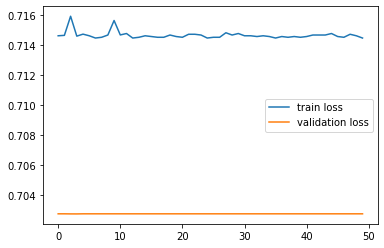

In [9]:
p.drawLossChange(train_losses, val_losses)

In [10]:
model = torch.load('./savedModels_randomOrder/LSTM')
all_targets, all_predictions = p.getReport(test_loader, model, device)

              precision    recall  f1-score   support

           0     0.8382    0.9788    0.9030      9178
           1     0.8665    0.5776    0.6932      9183
           2     0.8046    0.9342    0.8646      9456

    accuracy                         0.8312     27817
   macro avg     0.8365    0.8302    0.8203     27817
weighted avg     0.8361    0.8312    0.8207     27817



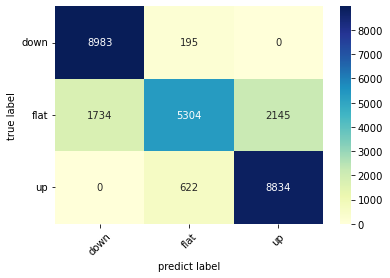

In [11]:
p.seeConfusionMatrix(all_targets,all_predictions)

### 发现在乱序数据上 对于label的预测效果很好